In [7]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import eikon as ek

In [8]:
ek.set_app_key('00d4d29ef3ef488a8d51239baa0ec01ca97e2a73')

In [20]:

def get_risk(rics):
    return (rics / rics.shift(1) - 1).dropna().std().values
def get_return(rics):
    return ((rics / rics.shift(1) - 1).dropna().mean() * np.sqrt(250)).values

rics = ['BA', 'C', 'AAL.O', 'NFLX.O']



data = pd.DataFrame()
for ric in rics:
    data[ric] = ek.get_timeseries(ric, fields='CLOSE', start_date='2012-06-18', end_date='2019-06-19')['CLOSE']



In [21]:
data = data.dropna()
risk_v = get_risk(data)
return_v = get_return(data)


In [22]:
risk_v

array([0.01509789, 0.01521408, 0.02300222, 0.02664637])

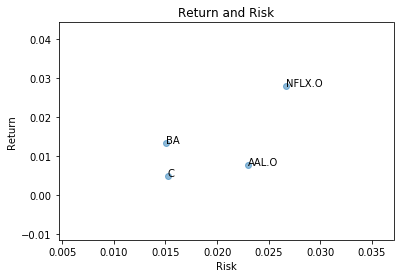

In [23]:
fig, ax = plt.subplots()
ax.scatter(x=risk_v, y=return_v, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')

for i, ric in enumerate(rics):
    ax.annotate(ric, (risk_v[i], return_v[i]))
    


plt.show()

# Build portfolio with random weights

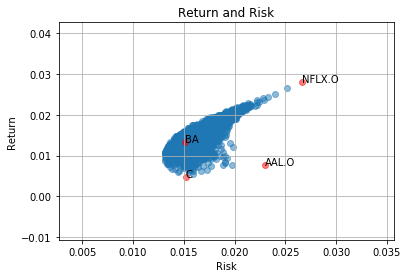

In [27]:
def random_weights(n):
    weights = np.random.rand(n)
    return weights / sum(weights)
def get_portfolio_risk(weights, normalized_data):
    portfolio_val = (normalized_data * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_data.index, data={'portfolio': portfolio_val})
    return (portfolio / portfolio.shift(1) - 1).dropna().std().values[0]
def get_portfolio_return(weights, normalized_data):
    portfolio_val = (normalized_data * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_data.index, data={'portfolio': portfolio_val})
    ret = get_return(portfolio)
    return ret[0]
risk_all = np.array([])
return_all = np.array([])
# for demo purpose, plot 3000 random portoflio
np.random.seed(0)
normalized_data = data / data.iloc[0, :]
for _ in range(0, 3000):
    weights = random_weights(len(rics))
    portfolio_val = (normalized_data * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=data.index, data={'portfolio': portfolio_val})
    risk = get_risk(portfolio)
    ret = get_return(portfolio)
    risk_all = np.append(risk_all, risk)
    return_all = np.append(return_all, ret)
    p = get_portfolio_risk(weights=weights, normalized_data=normalized_data)
fig, ax = plt.subplots()
ax.scatter(x=risk_all, y=return_all, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
for i, ric in enumerate(rics):
    ax.annotate(ric, (risk_v[i], return_v[i]))
ax.scatter(x=risk_v, y=return_v, alpha=0.5, color='red')
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
ax.grid()
plt.show()

# Efficient Frontier

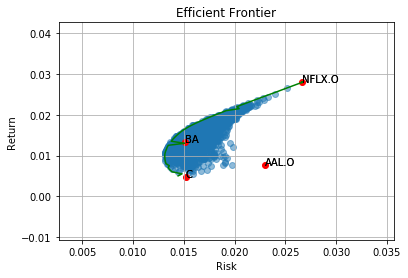

In [28]:
# optimizer
def optimize(data, rics, target_return=0.1):
    normalized_data = data / data.iloc[0, :]
    init_guess = np.ones(len(rics)) * (1.0 / len(rics))
    bounds = ((0.0, 1.0),) * len(rics)
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(normalized_data,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (normalized_data,),
                                     'fun': lambda inputs, normalized_data:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          normalized_data=normalized_data)}),
                       bounds=bounds)
    return weights.x
optimal_risk_all = np.array([])
optimal_return_all = np.array([])
for target_return in np.arange(0.005, .0402, .0005):
    opt_w = optimize(data=data, rics=rics, target_return=target_return)
    optimal_risk_all = np.append(optimal_risk_all, get_portfolio_risk(opt_w, normalized_data))
    optimal_return_all = np.append(optimal_return_all, get_portfolio_return(opt_w, normalized_data))
# plotting
fig, ax = plt.subplots()
# random portfolio risk return
ax.scatter(x=risk_all, y=return_all, alpha=0.5)
# optimal portfolio risk return
for i, ric in enumerate(rics):
    ax.annotate(ric, (risk_v[i], return_v[i]))
ax.plot(optimal_risk_all, optimal_return_all, '-', color='green')
# ric risk return
for i, ric in enumerate(rics):
    ax.annotate(ric, (risk_v[i], return_v[i]))
ax.scatter(x=risk_v, y=return_v, color='red')
ax.set(title='Efficient Frontier', xlabel='Risk', ylabel='Return')
ax.grid()
plt.savefig('return_risk_efficient_frontier.png', bbox_inches='tight')

The green line indicate the efficient frontier. Now we know the best allocation with a given target return. Next question, what is the best allocation overall? Portfolio performance can be evaluated with return/risk ratio (known as Sharpe Ratio). High Sharpe Ratio indicates good balance of return and risk. This allocation can be found by drawing a Capital Allocation line that tangent to the efficient frontier. The tangent point is the allocation yields highest Sharpe ratio. To learn more, you can take a look at this article on how to find the highest sharpe ratio from the efficient frontier with Capital Allocation Line (CAL).

https://corporatefinanceinstitute.com/resources/knowledge/finance/capital-allocation-line-cal-and-optimal-portfolio/?source=post_page---------------------------

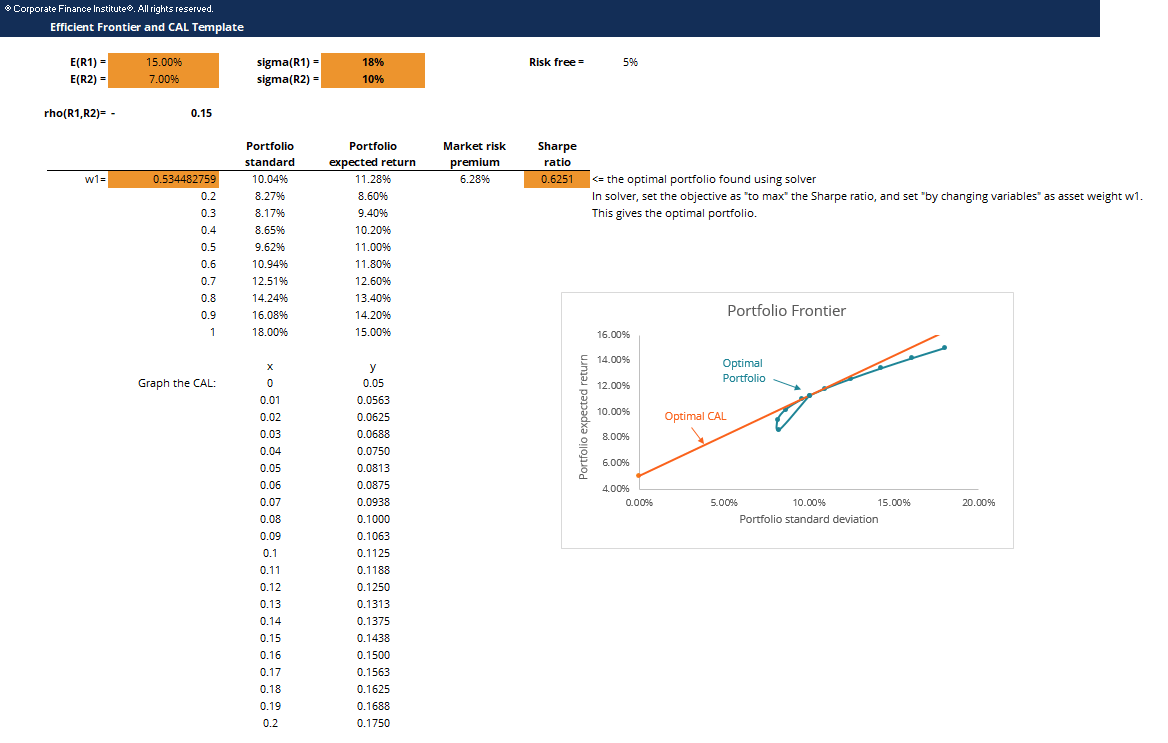

EFFICIENT FRONTIER & PORTFOLIO OPTIMIZATION # 

In the first part of this series, we looked at the underpinnings of Modern Portfolio Theory and generated an Efficient Frontier with the help of Monte Carlo Simulation. This post concludes the series by looking at the concept of portfolio optimization.

Capital Asset Pricing Model (CAPM). This post will not delve into this model now. However, we will utilize one of his contributions (the Sharpe Ratio) as criteria for choosing this “best combination”.

We will take advantage of the code we used in generating the efficient frontier in the last post with some minor adjustments. We already have expected returns and returns of our simulated portfolios. We are simply going to calculate their risk-adjusted returns (with the help of the Sharpe Ratio), and make a colour bar of the plots using the Sharpe Ratio as the colour map:

https://medium.com/data-py-blog/efficient-frontier-portfolio-optimization-with-python-part-2-2-a0f77230bfab

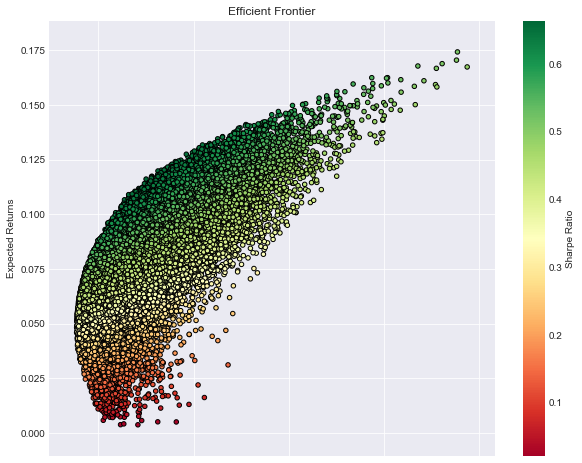

In [29]:
# import needed modules

import quandl

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt



# get adjusted closing prices of 5 selected companies with Quandl

quandl.ApiConfig.api_key = 'INSERT YOUR API KEY HERE'

selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']

data = quandl.get_table('WIKI/PRICES', ticker = selected,

                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },

                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate=True)



# reorganise data pulled by setting date as index with

# columns of tickers and their corresponding adjusted prices

clean = data.set_index('date')

table = clean.pivot(columns='ticker')



# calculate daily and annual returns of the stocks

returns_daily = table.pct_change()

returns_annual = returns_daily.mean() * 250



# get daily and covariance of returns of the stock

cov_daily = returns_daily.cov()

cov_annual = cov_daily * 250



# empty lists to store returns, volatility and weights of imiginary portfolios

port_returns = []

port_volatility = []

sharpe_ratio = []

stock_weights = []



# set the number of combinations for imaginary portfolios

num_assets = len(selected)

num_portfolios = 50000



#set random seed for reproduction's sake

np.random.seed(101)



# populate the empty lists with each portfolios returns,risk and weights

for single_portfolio in range(num_portfolios):

    weights = np.random.random(num_assets)

    weights /= np.sum(weights)

    returns = np.dot(weights, returns_annual)

    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))

    sharpe = returns / volatility

    sharpe_ratio.append(sharpe)

    port_returns.append(returns)

    port_volatility.append(volatility)

    stock_weights.append(weights)



# a dictionary for Returns and Risk values of each portfolio

portfolio = {'Returns': port_returns,

             'Volatility': port_volatility,

             'Sharpe Ratio': sharpe_ratio}



# extend original dictionary to accomodate each ticker and weight in the portfolio

for counter,symbol in enumerate(selected):

    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]



# make a nice dataframe of the extended dictionary

df = pd.DataFrame(portfolio)



# get better labels for desired arrangement of columns

column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]



# reorder dataframe columns

df = df[column_order]



# plot frontier, max sharpe & min Volatility values with a scatterplot

plt.style.use('seaborn-dark')

df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',

                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

plt.xlabel('Volatility (Std. Deviation)')

plt.ylabel('Expected Returns')

plt.title('Efficient Frontier')

plt.show()

Next up, let’s try to locate the optimal portfolio and another portfolio with the minimum volatility for the most risk-averse investor out there:

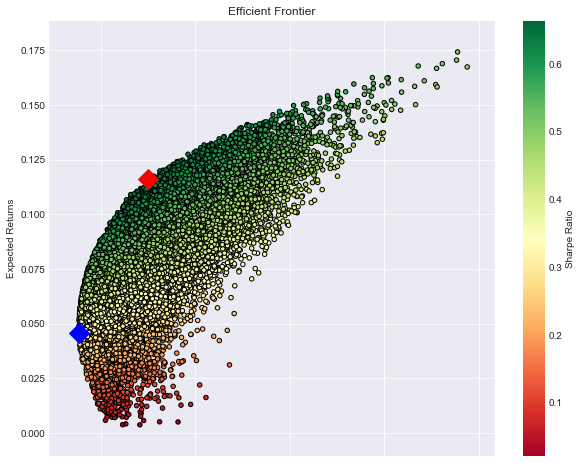

In [30]:
# find min Volatility & max sharpe values in the dataframe (df)

min_volatility = df['Volatility'].min()

max_sharpe = df['Sharpe Ratio'].max()



# use the min, max values to locate and create the two special portfolios

sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]

min_variance_port = df.loc[df['Volatility'] == min_volatility]



# plot frontier, max sharpe & min Volatility values with a scatterplot

plt.style.use('seaborn-dark')

df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',

                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)

plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )

plt.xlabel('Volatility (Std. Deviation)')

plt.ylabel('Expected Returns')

plt.title('Efficient Frontier')

plt.show()

An Efficient Frontier with a highlight of the optimal (as per the risk-adjusted return metric) portfolio and a portfolio with the minimum volatility.

To get specific details of these two special portfolios, let’s print their values out:

In [31]:
# print the details of the 2 special portfolios

print(min_variance_port.T)

print(sharpe_portfolio.T)

                 17879
Returns       0.045828
Volatility    0.138552
Sharpe Ratio  0.330761
CNP Weight    0.240327
F Weight      0.104659
WMT Weight    0.257760
GE Weight     0.001487
TSLA Weight   0.395767
                 31209
Returns       0.116145
Volatility    0.175045
Sharpe Ratio  0.663514
CNP Weight    0.372890
F Weight      0.008482
WMT Weight    0.404987
GE Weight     0.211450
TSLA Weight   0.002190


The most risk-averse investor would construct the minimum variance portfolio which has an expected return of 4.58% with an accompanying expected volatility of 13.86%. Investors seeking the maximum risk-adjusted return would opt for portfolio that with the maximum Sharpe Ratio which has an expected return of 11.61% with expected volatility pegged at 17.50%